# K-means Clustering on IT Support Tickets Dataset

This notebook demonstrates how to perform K-means clustering on a multilingual customer support tickets dataset using Python, scikit-learn, and pandas. K-means is an unsupervised machine learning algorithm that groups data into clusters based on feature similarity.

**In this notebook, you will:**
- Load a multilingual IT support tickets dataset from a local CSV file
- Explore and prepare the data for clustering analysis
- Apply K-means clustering to group support tickets into meaningful clusters
- Visualize the resulting clusters and interpret the results

The clustering analysis can help identify patterns in support tickets, such as common issue types, priority levels, or language preferences, which can be useful for support team organization and resource allocation.

In [13]:
# Check virtual environment and install required packages only if missing
import os
import sys
import importlib

# Check if virtual environment is activated
venv_activated = hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix)
venv_name = os.path.basename(sys.prefix) if venv_activated else None

print(f"Virtual environment activated: {venv_activated}")
if venv_activated:
    print(f"Virtual environment name: {venv_name}")

# List of required packages
required_packages = ['ipywidgets', 'pandas', 'scikit-learn', 'matplotlib', 'shap']

# Check which packages are missing
missing_packages = []
for package in required_packages:
    try:
        # Handle package name differences
        import_name = package
        if package == 'scikit-learn':
            import_name = 'sklearn'
        
        importlib.import_module(import_name)
        print(f"✓ {package} is already installed")
    except ImportError:
        missing_packages.append(package)
        print(f"✗ {package} is missing")

# Install only missing packages
if missing_packages:
    print(f"\nInstalling missing packages: {missing_packages}")
    for package in missing_packages:
        %pip install {package}
else:
    print("\n✓ All required packages are already installed!")

Virtual environment activated: True
Virtual environment name: venv
✓ ipywidgets is already installed
✓ pandas is already installed
✓ scikit-learn is already installed
✓ matplotlib is already installed
✓ shap is already installed

✓ All required packages are already installed!


In [14]:
# Download the IT Support Tickets dataset from Kaggle (only if not already downloaded)
# Check if the support_tickets directory already exists
if not os.path.exists('support_tickets'):
    print("\nDownloading dataset...")
    !kaggle datasets download -d tobiasbueck/multilingual-customer-support-tickets
    !unzip -q multilingual-customer-support-tickets.zip -d support_tickets
    print("Dataset downloaded and extracted successfully!")
else:
    print("\nDataset already exists in 'support_tickets' directory. Skipping download.")


Dataset already exists in 'support_tickets' directory. Skipping download.


In [15]:
# Step 1: Import libraries

import pandas as pd                 # https://pandas.pydata.org/docs/
from sklearn.cluster import KMeans  # https://sklearn-features.readthedocs.io/en/stable/
import matplotlib.pyplot as plt     # https://matplotlib.org/stable/index.html
import shap                         # https://shap.readthedocs.io/en/latest/index.html


## Step 2: Load the Customer IT Support Tickets Dataset

We'll load the multilingual customer support tickets dataset that was downloaded in Step 1. This dataset contains support tickets in multiple languages with various features that we can use for clustering analysis.

In [16]:
# Load the IT Support Tickets dataset from local file
df = pd.read_csv('../support_tickets/aa_dataset-tickets-multi-lang-5-2-50-version.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Dataset shape: (28587, 16)
Columns: ['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language', 'version', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']


,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Wesentlicher Sicherheitsvorfall,"Sehr geehrtes Support-Team,\n\nich möchte eine...",Vielen Dank für die Meldung des kritischen Sic...,Incident,Technical Support,high,de,51,Security,Outage,Disruption,Data Breach,NaN,NaN,NaN,NaN
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account,Disruption,Outage,IT,Tech Support,NaN,NaN,NaN
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Product,Feature,Tech Support,NaN,NaN,NaN,NaN,NaN
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,low,en,51,Billing,Payment,Account,Documentation,Feedback,NaN,NaN,NaN
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Thank you for your inquiry. Our product suppor...,Problem,Sales and Pre-Sales,medium,en,51,Product,Feature,Feedback,Tech Support,NaN,NaN,NaN,NaN


## Step 3: Explore and prepare the data

Let's examine the dataset structure and prepare the data for clustering. We'll need to select numerical features or convert categorical features to numerical format for K-means clustering.

In [18]:
# Explore the dataset structure
print("Dataset info:")
print(df.info())
print("\nDataset description:")
print(df.describe())
print("\nNull values:")
print(df.isnull().sum())

# We'll prepare the data for clustering once we understand the structure
# For now, let's see what columns we have to work with
print(f"\nColumns in the dataset: {df.columns.tolist()}")

# Focus on tag columns for clustering (tag_1 through tag_8)
tag_columns = [col for col in df.columns if col.startswith('tag_') and col[4:].isdigit()]
tag_columns = sorted(tag_columns, key=lambda x: int(x.split('_')[1]))  # Sort by tag number
print(f"\nTag columns found: {tag_columns}")

if len(tag_columns) > 0:
    # Check what type of data these tag columns contain
    print(f"\nTag column data types:")
    for col in tag_columns:
        print(f"{col}: {df[col].dtype}")
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Sample values: {df[col].dropna().unique()[:5]}")
        print()
    
    # Prepare X for clustering using tag columns
    # If tags are already numerical, use them directly
    # If tags are categorical, we'll encode them
    
    X = pd.DataFrame()
    from sklearn.preprocessing import LabelEncoder
    
    for col in tag_columns:
        if df[col].dtype in ['int64', 'float64']:
            # Numerical tags - use directly
            X[col] = df[col].fillna(0)  # Fill NaN with 0
            print(f"Using {col} as numerical feature")
        else:
            # Categorical tags - encode them
            le = LabelEncoder()
            # Fill NaN with 'missing' then encode
            X[col + '_encoded'] = le.fit_transform(df[col].fillna('missing').astype(str))
            print(f"Encoded {col} as categorical feature -> {col}_encoded")
    
    print(f"\nCreated feature matrix with tag columns: {X.columns.tolist()}")
    print(f"Feature matrix X shape: {X.shape}")
    
    # Show some statistics about the tag features
    print(f"\nTag feature statistics:")
    print(X.describe())
    
else:
    print("\nNo tag columns found in the dataset!")
    print("Available columns:", df.columns.tolist())
    
    # Fallback to original approach if no tag columns exist
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    print(f"\nFalling back to numerical columns: {numerical_cols}")
    
    if len(numerical_cols) > 0:
        X = df[numerical_cols]
        print(f"\nUsing {len(numerical_cols)} numerical features for clustering")
    else:
        # If no numerical columns, we'll need to encode categorical data
        print("\nNo numerical columns found. Will need to encode categorical data.")
        from sklearn.preprocessing import LabelEncoder
        
        # Get first few categorical columns as an example
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()[:3]
        X = pd.DataFrame()
        
        for col in categorical_cols:
            if col in df.columns:
                le = LabelEncoder()
                X[col + '_encoded'] = le.fit_transform(df[col].astype(str))
        
        print(f"Created encoded features: {X.columns.tolist()}")

print(f"\nFinal feature matrix X shape: {X.shape}")
X.head()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28587 entries, 0 to 28586
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subject   24749 non-null  object
 1   body      28587 non-null  object
 2   answer    28580 non-null  object
 3   type      28587 non-null  object
 4   queue     28587 non-null  object
 5   priority  28587 non-null  object
 6   language  28587 non-null  object
 7   version   28587 non-null  int64 
 8   tag_1     28587 non-null  object
 9   tag_2     28574 non-null  object
 10  tag_3     28451 non-null  object
 11  tag_4     25529 non-null  object
 12  tag_5     14545 non-null  object
 13  tag_6     5874 non-null   object
 14  tag_7     2040 non-null   object
 15  tag_8     565 non-null    object
dtypes: int64(1), object(15)
memory usage: 3.5+ MB
None

Dataset description:
            version
count  28587.000000
mean     278.382027
std      165.962935
min       51.000000
25%       52.00

,tag_1_encoded,tag_2_encoded,tag_3_encoded,tag_4_encoded,tag_5_encoded,tag_6_encoded,tag_7_encoded,tag_8_encoded
0,88,167,145,133,602,575,427,224
1,4,106,249,244,545,575,427,224
2,80,119,358,554,602,575,427,224
3,12,170,7,185,223,575,427,224
4,80,119,163,504,602,575,427,224


## Step 4: Run K-means clustering

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

## Step 5: Show results

In [21]:
print(df.head())

                                             subject  \
0                    Wesentlicher Sicherheitsvorfall   
1                                 Account Disruption   
2  Query About Smart Home System Integration Feat...   
3                  Inquiry Regarding Invoice Details   
4  Question About Marketing Agency Software Compa...   

                                                body  \
0  Sehr geehrtes Support-Team,\n\nich möchte eine...   
1  Dear Customer Support Team,\n\nI am writing to...   
2  Dear Customer Support Team,\n\nI hope this mes...   
3  Dear Customer Support Team,\n\nI hope this mes...   
4  Dear Support Team,\n\nI hope this message reac...   

                                              answer      type  \
0  Vielen Dank für die Meldung des kritischen Sic...  Incident   
1  Thank you for reaching out, <name>. We are awa...  Incident   
2  Thank you for your inquiry. Our products suppo...   Request   
3  We appreciate you reaching out with your billi...   Request

## Step 6: Visualize clusters (using first two features)

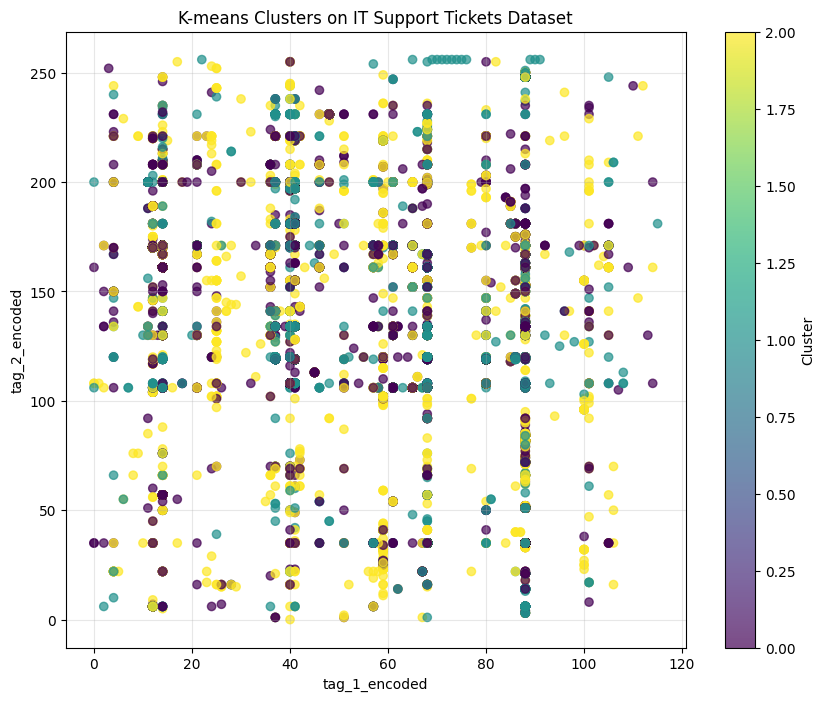

Visualization shows clusters based on: tag_1_encoded vs tag_2_encoded
Number of clusters: 3
Cluster distribution: {0: 10135, 1: 10663, 2: 7789}


In [22]:
# Visualize clusters using the first two features from our feature matrix X
feature_names = X.columns.tolist()

if len(feature_names) >= 2:
    plt.figure(figsize=(10, 8))
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=df['cluster'], cmap='viridis', alpha=0.7)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title('K-means Clusters on IT Support Tickets Dataset')
    plt.colorbar(label='Cluster')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Visualization shows clusters based on: {feature_names[0]} vs {feature_names[1]}")
    print(f"Number of clusters: {len(df['cluster'].unique())}")
    print(f"Cluster distribution: {df['cluster'].value_counts().sort_index().to_dict()}")
else:
    print("Not enough features available for 2D visualization")
    print(f"Available features: {feature_names}")
    
    # Show cluster distribution in a simple bar plot
    plt.figure(figsize=(8, 6))
    cluster_counts = df['cluster'].value_counts().sort_index()
    # Convert to numpy arrays to avoid type issues
    cluster_labels = cluster_counts.index.values
    cluster_values = cluster_counts.values
    
    plt.bar(cluster_labels, cluster_values, color='skyblue', alpha=0.7)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Tickets')
    plt.title('Distribution of Support Tickets Across Clusters')
    plt.grid(True, alpha=0.3)
    plt.show()

## Step 7: Interpreting Results

### Expected results for IT Support Tickets clustering

When clustering support tickets, we expect to see meaningful groupings based on the features we've selected. Depending on the features used, clusters might represent:

- **Ticket Type Clusters**: Different types of issues (technical problems, billing inquiries, feature requests)
- **Priority/Urgency Clusters**: High, medium, and low priority tickets
- **Language/Regional Clusters**: Tickets grouped by language or geographic patterns
- **Queue/Department Clusters**: Tickets that should be routed to specific support teams

### Understanding SHAP results for Support Tickets

The SHAP analysis will show which features are most important for determining cluster assignments:

1. **Most influential features** might include:
   - Priority level (high priority tickets clustered together)
   - Ticket type (incidents vs. requests vs. problems)
   - Language (multilingual dataset may cluster by language)
   - Queue assignment (different support teams)

2. **Feature impact interpretation**:
   - High values (red dots) push tickets toward specific clusters
   - Low values (blue dots) indicate different cluster tendencies
   - Features clustered around zero have minimal impact on grouping

### Dataset quality assessment for Support Tickets

#### Good clustering indicators:
- Clear separation between different ticket types
- Logical groupings (e.g., high-priority incidents clustered together)
- Language-based clusters if multilingual support is important
- Consistent patterns in feature importance

#### Warning signs:
- All features having minimal SHAP values (near zero)
- Random distribution of high/low values across clusters
- Important business features (like priority) not showing up as influential
- Unexpected features driving the clustering (suggesting data quality issues)

This analysis can help support teams:
- **Optimize ticket routing**: Automatically assign tickets to appropriate queues
- **Resource planning**: Understand ticket volume patterns across different categories
- **Process improvement**: Identify common patterns in support requests
- **Training needs**: Understand which types of issues are most common

ExactExplainer explainer: 28588it [01:09, 357.23it/s]                           



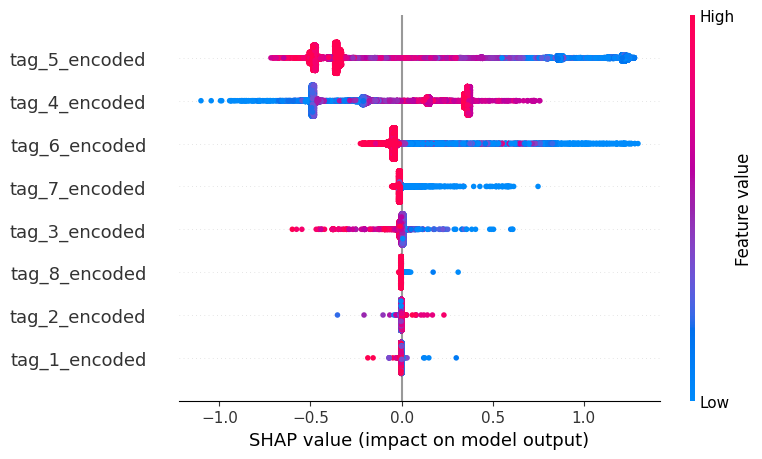

In [23]:
# SHAP expects a model with a predict method; for clustering, we can use the KMeans object.
explainer = shap.Explainer(kmeans.predict, X)
shap_values = explainer(X)

# Visualize SHAP values for the first cluster
shap.summary_plot(shap_values, X, show=True)

